In [4]:
%matplotlib notebook
import os
import sys
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from rdkit import Chem

paths = [os.path.abspath(path) for path in ["..", "../Source"]]
for path in paths:
    if path not in sys.path:
        sys.path.append(path)
from config import ROOT_DIR

In [5]:
def read_results(path):
    with open(os.path.join(path, "metrics.json"), "r") as file:
        return json.load(file)

In [6]:
Ln_metals = ['La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', ]
An_metals = ['Ac', 'Th', 'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf']

other_metals = ['Li', 'Be', 'Na', 'Mg', 'Al', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn',
                'Ga', 'Rb', 'Sr', 'Y', 'Zr', 'Mo', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Cs', 'Ba', 'Hf', 'Re',
                'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi']

### GCNN_FCNN with conditions (whole dataset)

<IPython.core.display.Javascript object>


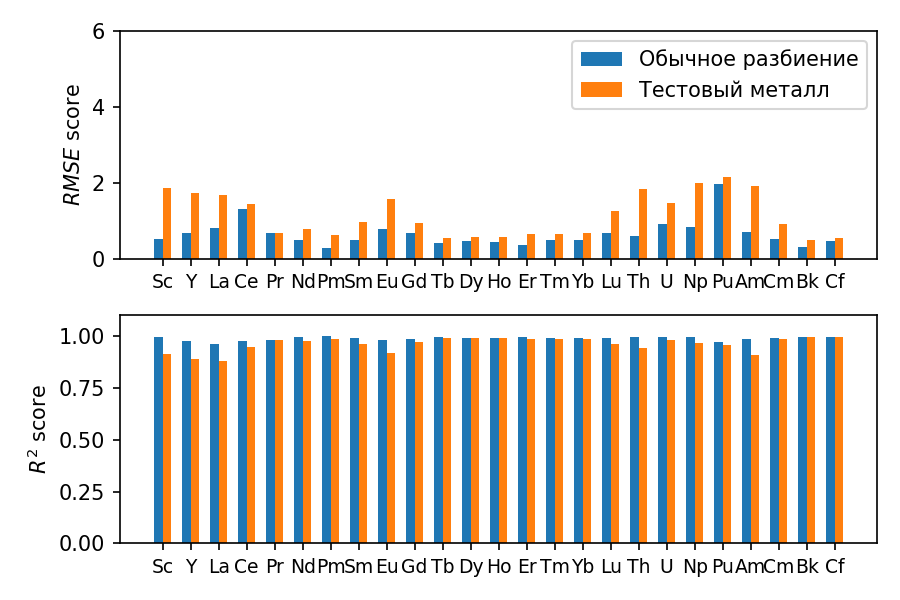

In [7]:
base_path = ROOT_DIR / "Output/WithCondAdd/5fold"
metals = list(set(["Y", "Sc"] + Ln_metals + An_metals) - {"Ac", "Pa"})

metals = np.array(metals)[np.array([Chem.Atom(metal).GetAtomicNum() for metal in metals]).argsort()]
folders = {f.split("_")[0]: os.path.join(base_path, f) for f in os.listdir(base_path)}
results = [read_results(folders[metal]) for metal in metals]

rmse = np.array([result["logK_test_RMSE"] for result in results])
r2 = np.array([result["logK_test_R2"] for result in results])

# # #

with open(ROOT_DIR / "Output/WithCondAdd/final_5fold_regression_2023_06_10_07_58_17/metal_val_metrics.json", "r") as file:
    soft_results = json.load(file)
soft_results = [soft_results[metal] for metal in metals]

soft_rmse = np.array([result["RMSE"] for result in soft_results])
soft_r2 = np.array([result["R2"] for result in soft_results])

# # #

fig, ax = plt.subplots(2, 1, figsize=(6, 4))

width = 0.3
fmt="%.2lf"
float_fontsize=8

# draw bars
ind = np.arange(len(metals))

soft_rmse_bar = ax[0].bar(ind - width/2, soft_rmse, width, label="Обычное разбиение")
soft_r2_bar = ax[1].bar(ind - width/2, soft_r2, width)

rmse_bar = ax[0].bar(ind + width/2, rmse, width, label="Тестовый металл")
r2_bar = ax[1].bar(ind + width/2, r2, width)

ax[0].set_ylabel("$RMSE$ score")
ax[0].set_ylim(0, 6)

ax[1].set_ylabel("$R^2$ score")
ax[1].set_ylim(0, 1.1)

ax[0].set_xticks(range(len(metals)), metals, fontsize=9)
ax[1].set_xticks(range(len(metals)), metals, fontsize=9)

fig.tight_layout()
ax[0].legend()
plt.show()

In [8]:
results_2021 = {
    "La": {"R2": 0.7323232323232324, "RMSE": 2.8999999999999995},
    "Ce": {"R2": 0.8131313131313134, "RMSE": 2.4250000000000003},
    "Pr": {"R2": 0.7070707070707072, "RMSE": 2.3249999999999997},
    "Nd": {"R2": 0.8585858585858588, "RMSE": 1.8500000000000005},
    "Sm": {"R2": 0.7828282828282829, "RMSE": 1.8249999999999997},
    "Eu": {"R2": 0.6161616161616162, "RMSE": 2.8999999999999995},
    "Gd": {"R2": 0.8636363636363639, "RMSE": 2.375},
    "Tb": {"R2": 0.4848484848484851, "RMSE": 4.325},
    "Dy": {"R2": 0.7474747474747474, "RMSE": 2.1999999999999997},
    "Ho": {"R2": 0.888888888888889, "RMSE": 2.0500000000000003},
    "Er": {"R2": 0.7424242424242425, "RMSE": 3.2750000000000004},
    "Tm": {"R2": 0.8484848484848485, "RMSE": 2},
    "Yb": {"R2": 0.7626262626262629, "RMSE": 2.375},
    "Lu": {"R2": 0.8484848484848485, "RMSE": 2.25},
}

<IPython.core.display.Javascript object>


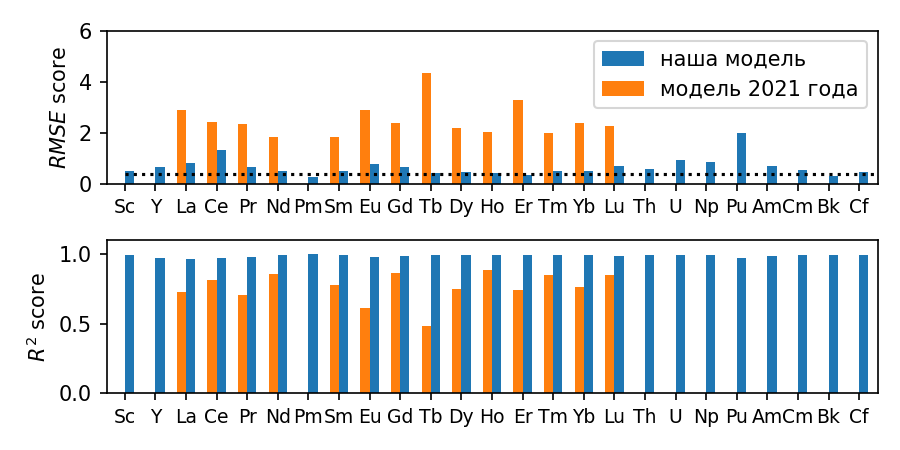

In [22]:
metals = list(set(["Y", "Sc"] + Ln_metals + An_metals) - {"Ac", "Pa"})
metals = np.array(metals)[np.array([Chem.Atom(metal).GetAtomicNum() for metal in metals]).argsort()]

with open(ROOT_DIR / "Output/WithCondAdd/final_5fold_regression_2023_06_10_07_58_17/metal_val_metrics.json", "r") as file:
    results = json.load(file)

rmse = np.array([results[metal]["RMSE"] for metal in metals])
r2 = np.array([results[metal]["R2"] for metal in metals])

rmse_2021 = np.array([results_2021[metal]["RMSE"] if metal in results_2021 else 0 for metal in metals])
r2_2021 = np.array([results_2021[metal]["R2"] if metal in results_2021 else 0 for metal in metals])

fig, ax = plt.subplots(2, 1, figsize=(6, 3))

width = 0.3
fmt="%.2lf"
float_fontsize=8

# draw bars
ind = np.arange(len(metals))

ax[0].bar(ind + width/2, rmse, width, label="наша модель")
ax[1].bar(ind + width/2, r2, width)

ax[0].bar(ind - width/2, rmse_2021, width, label="модель 2021 года")
ax[1].bar(ind - width/2, r2_2021, width)

ax[0].hlines(0.4, 0, len(metals), color="black", linestyles="dotted")

ax[0].set_ylabel("$RMSE$ score")
ax[0].set_ylim(0, 6)

ax[1].set_ylabel("$R^2$ score")
ax[1].set_ylim(0, 1.1)

ax[0].set_xticks(range(len(metals)), metals, fontsize=9)
ax[1].set_xticks(range(len(metals)), metals, fontsize=9)

ax[0].set_xlim(-(width+0.3), len(metals)-1+(width + 0.3))
ax[1].set_xlim(-(width+0.3), len(metals)-1+(width + 0.3))
fig.tight_layout()
ax[0].legend()
plt.show()